In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy


import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
import time

%matplotlib inline
np.random.seed(1)

/home/aswin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aswin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aswin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aswin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:461: Futu

In [2]:
#hist_bb = np.load("hist_bb.npy")
#hist_tt = np.load('hist_tt.npy')

In [3]:
hist_bb = np.load('b_phipt.npy')
hist_tt = np.load('t_phipt.npy')


In [4]:
bb_X_train = hist_bb[:18000]
tt_X_train = hist_tt[:18000]

bb_Y_train = np.zeros(18000)
tt_Y_train = np.ones(18000)



bb_X_test = hist_bb[18000:20000]
tt_X_test = hist_tt[18000:20000]

bb_Y_test = np.zeros(2000)
tt_Y_test = np.ones(2000)





In [5]:
X_train = np.concatenate((bb_X_train,tt_X_train), axis = 0).reshape(-1,20,20,1)
X_test = np.concatenate((bb_X_test,tt_X_test), axis = 0).reshape(-1,20,20,1)

Y_train = np.concatenate((bb_Y_train,tt_Y_train)).reshape(len(X_train),1)
Y_test = np.concatenate((bb_Y_test, tt_Y_test)).reshape(len(X_test),1)



In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32 ,[None, n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y
    

In [7]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [3,3,1,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3,3,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W3 = tf.get_variable("W3", [3,3,16,32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2,
                   "W3": W3}
    
    
    return parameters
    
    

In [8]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    
    W2 = parameters['W2']
    
    W3 = parameters['W3']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    
    
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID' )
    
    
    Z2 =  tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    

    P2 =  tf.nn.max_pool(A2, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'VALID' )
    
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding =  'SAME')
    A3 = tf.nn.relu(Z3)
    
    P3 = tf.nn.max_pool(A3, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'VALID' )
    
    
    
    F = tf.contrib.layers.flatten(P3)
    
    A4 = tf.nn.relu(F)
    
    
    
    A5 =  tf.contrib.layers.fully_connected(A4, 120, activation_fn = tf.nn.relu)
    A6 =  tf.contrib.layers.fully_connected(A5, 40, activation_fn = tf.nn.relu)
    #A7 =  tf.contrib.layers.fully_connected(A6, 40, activation_fn = tf.nn.relu)
    #A8 =  tf.contrib.layers.fully_connected(A7, 5, activation_fn = tf.nn.relu)
    Z  = tf.contrib.layers.fully_connected(A6, 1 ,activation_fn = None)
    
    
    
    
    return Z
    
    
    

In [9]:
def compute_cost(Z, Y):
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z, labels = Y))
    
    return cost

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 10, minibatch_size = 64, print_cost = True):
    
    
    
    
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m,n_H0,n_W0,n_C0) = X_train.shape
    
    n_y = Y_train.shape[1]
    
    costs = []
    
    X,Y = create_placeholders(n_H0, n_W0,n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z =  forward_propagation(X, parameters)
    
    cost = compute_cost(Z,Y)
    
    optimizer =  tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    
    
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibathches = int(m/minibatch_size)
            seed = seed + 1
            
            minibatches =  random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost/ num_minibathches
                
                
                
                
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        plt.plot(np.squeeze(costs))
        
        plt.xlabel('iterations(per tens)')
        plt.ylabel('cost')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        predict_op = tf.nn.sigmoid(Z)
        
        correct_prediction = tf.equal(tf.round(predict_op), Y)
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print(accuracy)
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        return train_accuracy, test_accuracy, parameters
        
        
        
                
                
                
                

Cost after epoch 0: 0.014492
Cost after epoch 5: 0.000001


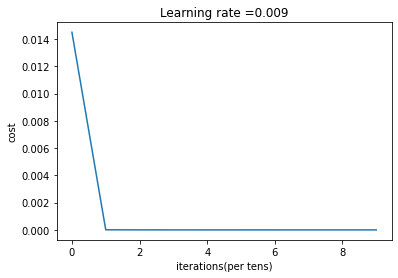

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [14]:
train_accuracy, test_accuracy, parameters = model(X_train, Y_train, X_test, Y_test)